In [19]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [20]:
# Load the dataset
file_path = r'C:\Users\sreep\project-sree-paada\data\kidney_disease.csv'
df = pd.read_csv(file_path)

In [21]:
# Data preprocessing: Handle missing values
df.fillna(df.mean(numeric_only=True), inplace=True)  # Fill numeric NaNs with mean
df.ffill(inplace=True)  # Fill remaining NaNs

In [22]:
# Encoding target variable 'classification' as binary
df['classification'] = df['classification'].apply(lambda x: 1 if x == 'ckd' else 0)


In [23]:
# Label encoding for non-numeric columns
for col in df.drop(columns=['classification', 'id']).columns:
    if df[col].dtype == 'object':
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])

In [24]:
# Prepare data
X = df.drop(columns=['classification', 'id']).values
t = df['classification'].values

In [25]:
# Initialize a range of hyperparameters
sig_sq_values = [1, 10, 100, 1000]

In [26]:
# Logistic function
def logistic(x):
    return 1 / (1 + np.exp(-x))

In [27]:
# Gradient calculation
def gradient(w, X, t, sig_sq):
    p = logistic(X @ w)
    return -w / sig_sq + X.T @ (t - p)

In [28]:
# Hessian calculation
def hessian(w, X, sig_sq):
    p = logistic(X @ w)
    W = np.diag(p * (1 - p))
    return -(1.0 / sig_sq) * np.eye(len(w)) - X.T @ W @ X

In [29]:
# Cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []

In [30]:
# Loop through different hyperparameter values
for sig_sq in sig_sq_values:
    print(f"Testing hyperparameter sig_sq = {sig_sq}")

    cv_accuracies = []
    cv_precisions = []
    cv_recalls = []
    cv_f1_scores = []

    for fold, (train_idx, test_idx) in enumerate(kf.split(X, t), start=1):
        # Split data into train and test
        X_train, X_test = X[train_idx], X[test_idx]
        t_train, t_test = t[train_idx], t[test_idx]

        # Initialize weights
        w = np.zeros(X_train.shape[1])

        # Perform MAP estimation
        for _ in range(10):
            w -= np.linalg.inv(hessian(w, X_train, sig_sq)) @ gradient(w, X_train, t_train, sig_sq)

        # Predict the probabilities and classes for the test set
        def predict_probability(X, w):
            return logistic(X @ w)

        def predict_class(X, w):
            probabilities = predict_probability(X, w)
            return (probabilities >= 0.5).astype(int)

        predicted_classes_test = predict_class(X_test, w)

        # Evaluate performance for the current fold
        accuracy = accuracy_score(t_test, predicted_classes_test)
        precision = precision_score(t_test, predicted_classes_test)
        recall = recall_score(t_test, predicted_classes_test)
        f1 = f1_score(t_test, predicted_classes_test)

        # Store metrics
        cv_accuracies.append(accuracy)
        cv_precisions.append(precision)
        cv_recalls.append(recall)
        cv_f1_scores.append(f1)

    # Aggregate results
    avg_accuracy = np.mean(cv_accuracies)
    avg_precision = np.mean(cv_precisions)
    avg_recall = np.mean(cv_recalls)
    avg_f1_score = np.mean(cv_f1_scores)

    results.append({
        'sig_sq': sig_sq,
        'accuracy': avg_accuracy,
        'precision': avg_precision,
        'recall': avg_recall,
        'f1_score': avg_f1_score
    })

Testing hyperparameter sig_sq = 1
Testing hyperparameter sig_sq = 10
Testing hyperparameter sig_sq = 100
Testing hyperparameter sig_sq = 1000


C:\Users\sreep\AppData\Local\Temp\ipykernel_23844\4032655376.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


In [31]:
# Convert results to DataFrame for visualization
results_df = pd.DataFrame(results)

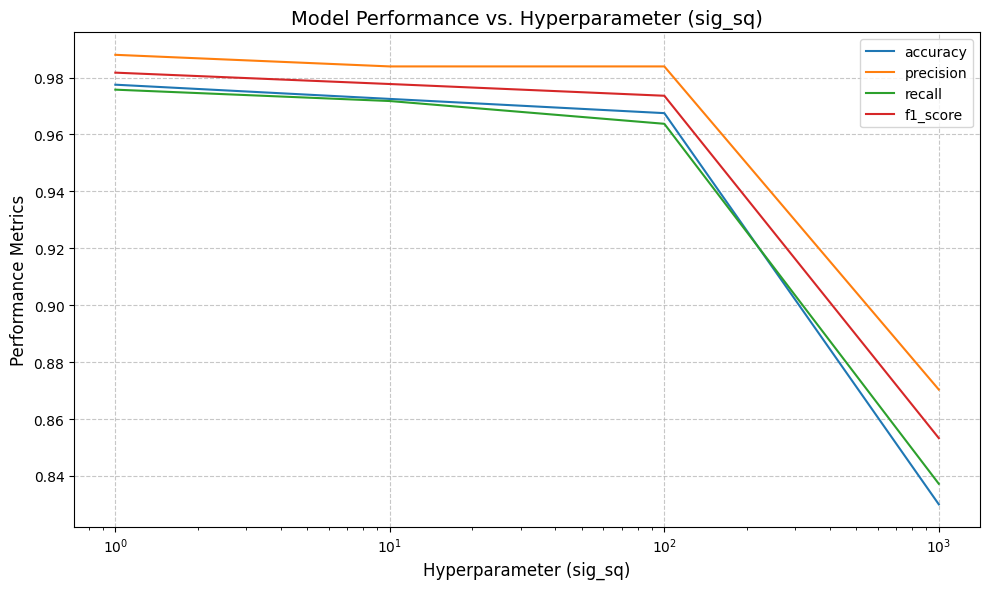

In [ ]:
# Visualization
plt.figure(figsize=(10, 6))
for metric in ['accuracy', 'precision', 'recall', 'f1_score']:
    plt.plot(results_df['sig_sq'], results_df[metric], label=metric)

plt.xscale('log')  # Log scale for hyperparameters
plt.title("Model Performance vs. Hyperparameter (sig_sq)", fontsize=14)
plt.xlabel("Hyperparameter (sig_sq)", fontsize=12)
plt.ylabel("Performance Metrics", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("performance_vs_sig_sq.png")
plt.show()

In [ ]:
# Display the best results
best_result = results_df.loc[results_df['accuracy'].idxmax()]
print("\nBest Hyperparameter Results:")
print(f"  sig_sq: {best_result['sig_sq']}")
print(f"  Accuracy: {best_result['accuracy']:.4f}")
print(f"  Precision: {best_result['precision']:.4f}")
print(f"  Recall: {best_result['recall']:.4f}")
print(f"  F1 Score: {best_result['f1_score']:.4f}")


Best Hyperparameter Results:
  sig_sq: 1.0
  Accuracy: 0.9775
  Precision: 0.9880
  Recall: 0.9758
  F1 Score: 0.9817
